In [3]:
import numpy as np
import matplotlib.pyplot as plt

from pyomo.core.base.objective import minimize
from pyomo.environ import ConcreteModel, AbstractModel, Var, Objective, Constraint, ConstraintList, SolverFactory
from pyomo.environ import maximize, Binary, RangeSet, Set, NonNegativeReals, Reals

from utils import *

# Interger Linear Programming for Protein Folding
In this notebook, we show different integer linear programming (ILP) models for solving semplified versions of the protein folding problem.  
Predicting the three-dimensional structure of a protein, given its amino acid sequence, is a critical task in biochemistry and computational biology since it can help to better understand some diseases and the development of new drugs.
Since the search space is huge brute force is not an option and atomic-level modeling is computationally prohibitive, so many simplified models and approaches have been developed during the years. One of particular interest is the HP model.

## HP model
The HP model relies on three semplifications:
1. divide the 20 amino acids in two 2 groups:
    - Hydrophobic (non-polar) indicated with H
    - Hydrophilic (polar) indicated with P
Hence, our protein sequence becomes a binary string
2. Proteins in a cell are surrounded by water so the H amino acids are likely to be forced in the interior of the folded protein, while the P stay on the exterior.
3. Stability of the folding is maximized by the number of bonds between hydrophobic amino acids (H-H bonds)

In the first two sections of this notebook we are going to show different ILP models based on the HP model and for simplicity we are going to predict the 2-D structure of the protein by considering it as a binary string embed on a two-dimensional grid.

In [5]:
protein_sequence = "HPHHPPHH" #"HPPHHHPHPHPPHHPHHH"
protein_binary_sequence = get_binary_string(protein_sequence)

print("Protein sequence:", protein_sequence)
print("Protein binary sequence:", protein_binary_sequence)
n = len(protein_sequence)
print("Protein length:", n)

print("Offset: ", calculate_offset(protein_binary_sequence))

Protein sequence: HPHHPPHH
Protein binary sequence: 10110011
Protein length: 8
Offset:  2


## Basic Model
This 

In [55]:
def ILP_basic_formulation(binary_seq):
    model = ConcreteModel()

    ###################
    #   VARIABLES     #
    ###################

    n = len(binary_seq) # sequence length
    grid_size = n*n
    offset = calculate_offset(binary_seq)

    # Set of indices
    model.I = RangeSet(0, n - 1)    # character in the sequence index
    model.I1 = RangeSet(0, n - 2)
    model.P = RangeSet(0, grid_size - 1)    # point on grid index
    model.H = Set(initialize=get_hydrophobic_set(binary_seq))   # set of indexes in sequence where value is 1 (hydrophobic)

    # Decision variables
    model.x = Var(model.I, model.P, within=Binary)
    model.h = Var(model.P, within=Binary)
    model.c = Var(model.P, model.P, within=Binary) 


    ###################
    #   CONSTRAINTS   #
    ###################

    model.constraints = ConstraintList()

    # Each amino acid in the sequence is assigned to exactly one point on the grid
    for i in model.I:
        model.constraints.add(expr = ( sum( model.x[i, p] for p in model.P ) == 1 ) )
    
    # Each point on the grid is assigned at most one amino acid in the sequence
    for i in model.I:
        for j in model.I:
            for p in model.P:
                if i != j:
                    model.constraints.add(expr = ( model.x[i, p] + model.x[j, p] <= 1 ) )
    
    # Adjacent amino acids in the sequence are assigned to neighboring points on the grid
    for i in model.I1:
        for p in model.P:
            model.constraints.add(expr = ( model.x[i, p] <= sum( model.x[i+1, q] for q in neighboring_set(p, n) ) ) )
            model.constraints.add(expr = ( model.x[i+1, p] <= sum( model.x[i, q] for q in neighboring_set(p, n) ) ) )

    # Constraints to detect contacts, i.e. edges (p,q) on the grid where neighboring points p and q
    # have been assigned non-adiancent characters in the sequence with value 1
    for p in model.P:
        model.constraints.add(expr = ( model.h[p] == sum( model.x[i, p] for i in model.H ) ) )
    for p in model.P:
        for q in model.P:
            if p != q:
                model.constraints.add(expr = ( model.h[p] + model.h[q] >= 2*model.c[p, q] ) )
                model.constraints.add(expr = ( model.h[p] + model.h[q] <= 1 + model.c[p, q] ) ) # added

    
    ###################
    #   OBJECTIVE     #
    ###################
    model.obj = Objective(expr = ( sum( model.c[p, q] for p in model.P for q in model.P ) - offset ), sense = maximize)


    ###################
    #   SOLVER        #
    ###################
    sol = SolverFactory('gurobi').solve(model, tee=True)

    # CHECK SOLUTION STATUS

    # Get a JSON representation of the solution
    sol_json = sol.json_repn()

    if sol_json['Solver'][0]['Status'] == 'ok':
        print("Optimal solution value:", model.obj())
        print("\tValues of the decision variables:", [[model.x[i, p]() for p in model.P] for i in model.I]) 
    else:
        print('Error in solving the model')

    return [[model.x[i, p]() for p in model.P] for i in model.I]



x = ILP_basic_formulation(protein_binary_sequence)

Set parameter Username
Academic license - for non-commercial use only - expires 2024-05-18
Read LP format model from file /var/folders/57/yk3w62md44z9m6ndy61mkkz80000gn/T/tmp_81udniw.pyomo.lp
Reading time = 0.00 seconds
x776: 1931 rows, 776 columns, 5714 nonzeros
Gurobi Optimizer version 10.0.1 build v10.0.1rc0 (mac64[arm])

CPU model: Apple M1 Pro
Thread count: 10 physical cores, 10 logical processors, using up to 10 threads

Optimize a model with 1931 rows, 776 columns and 5714 nonzeros
Model fingerprint: 0x1cb68b6b
Variable types: 1 continuous, 775 integer (775 binary)
Coefficient statistics:
  Matrix range     [1e+00, 2e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+00]
Found heuristic solution: objective 30.0000000
Presolve removed 1244 rows and 441 columns
Presolve time: 0.02s
Presolved: 687 rows, 335 columns, 2492 nonzeros
Variable types: 0 continuous, 335 integer (335 binary)

Root relaxation: objective 8.300000e+01, 435 i

[10, 5, 4, 9, 8]
[(2, 0), (1, 0), (0, 4), (1, 4), (1, 3)]


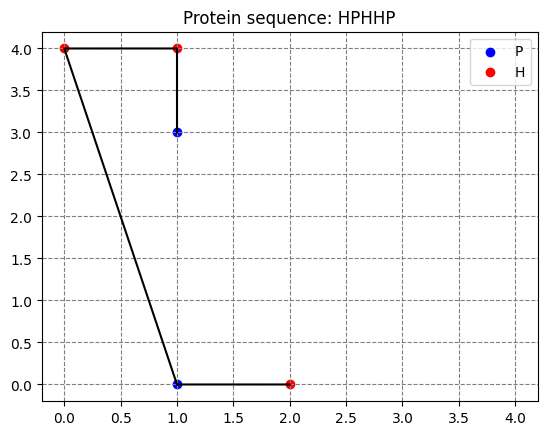

In [53]:
positions = []
pos = []
for i in range(len(x)):
    for p in range(len(x[i])):
        if x[i][p] == 1:
            positions.append((p // n, p % n))
            pos.append(p)
print(pos)
print(positions)

plot_folding(protein_binary_sequence, protein_sequence, positions, n-1)

## Protein folding on lattices : An integer programming approach
In this section we took inspiration from the paper [Protein folding on lattices : An integer programming approach](https://repository.iimb.ac.in/bitstream/123456789/631/1/wp.iimb.199.pdf) and tried to reproduce their results.  
The aim is to predict 2D - HP protein folding on a rectangular lattice and formulate the model as an ILP problem.  

### Formulation
- $ s_k $ : amino acid that can be either hydrophobic (H) or hydrophilic (P)
- $ s_t $ and $ s_{t+1} $ are adjacent on the chain, with $ 1 \leq t \leq n-1 $
- $ H $ : set of hydrophobic amino acids
- Consider a $ (2n-1) * (2n-1) $ grid
- $ (i,j) $ : lattice point or vertex in the grid, $ 1 \leq i,j \leq 2n-1 $
- $ (i,j) $ and $ (u,v) $ are neighbours if one of the following is true:
    - $ u=i \qquad\text{and}\qquad v=j+1 \qquad\text{or}\qquad v=j-1 $
    - $ v=j \qquad\text{and}\qquad u=i+1 \qquad\text{or}\qquad u=i-1 $
- $ N_{ij} $ : set of adjacent vertices to vertex $ (i,j) $
- *Connected neighbours* : pair of amino acids that occure in successive positions in the chain
- *Topological neighbours* : pair of non-successive amino acids that are adjacent in the embedding  

- Define grid graph $ G = (V,E) $ where every edge is of the form $ ((i,j),(u,v)) $ where $ (u,v) \in N_{ij} $ with $ 1 \leq i,j \leq 2n-1 $
- First amino acid $ s_1 $ is placed at the center of the grid $ (n,n) $

### Goal
Place amino acids $ s_k $ at vertices $ (i,j) $ such that the following are satisfied
- each amino acid is placed at exactly one vertex
- each vertex has at most one amino acid
- amino acids adjacent on the chain must be placed at adjacent vertices  

And maximize the number of amino acids H that are topologically adjacent.

### Decision Variables
$$ x_{ij}^{k} =
\begin{cases}
      1 & \text{if $ s_k $ is placed on $ (i,j) $}\\
      0 & \text{otherwise}
    \end{cases}   
$$
$$ y_{ij}^{uv} =
\begin{cases}
      1 & \text{if $ s_{a},s_{b} \in H $ are placed on $ (i,j) $ and $ (u,v) $ s.t. $ (u,v) \in N_{ij} $}\\
      0 & \text{otherwise}
    \end{cases}   
$$

### Objective function
$$ max \sum_{((i,j),(u,v)) \in E} { y_{ij}^{uv} } $$

### Constraints
1. $ s_{1} $ is placed on $ (n,n) $
$$ x_{nn}^1 = 1 $$
2. Each vertex has at most one amino acid
$$ \sum_{k=1}^{n} {x_{ij}^{k}} \leq 1 \qquad \forall (i,j) \qquad 1 \leq i,j \leq 2n-1 $$ 
3. Each amino acid is placed at exactly one vertex
$$ \sum_{i=1}^{2n-1} {\sum_{j=1}^{2n-1} {x_{ij}^{k}}} = 1 \qquad \forall k \qquad 1 \leq k \leq n $$ 
4. If amino acid $ k $ is placed at $ (i,j) $ then $ k+1 $ is placed at a vertex $ (u,v) \in N_{ij} $
$$ x_{ij}^{k} \leq \sum_{(u,v) \in N_{ij}} { x_{uv}^{k+1} } \qquad \forall (i,j) \qquad 1 \leq i,j \leq 2n-1 \qquad \forall k \qquad 1 \leq k \leq n-1 $$
5. 6 If $ y_{ij}^{uv} = 1 $ only if two H amino acids are placed at neighbours vertices
$$ y_{ij}^{uv} \leq \sum_{k \in H} { x_{ij}^{k} } \qquad \forall ((i,j),(u,v)) $$ 
$$ y_{ij}^{uv} \leq \sum_{k \in H} { x_{uv}^{k} } \qquad \forall ((i,j),(u,v)) $$ 
7. $ x_{ij}^{k} $ is binary {0, 1}  
8. $ y_{ij}^{uv} $ is binary {0, 1}

### Additional constraints
Instead of just restricting the positions of neighbours amino acid $ s_k $ and $ s_{k+1} $, let's restrict the positions of $ s_k $ and $ s_{k+t} $ ($ s_{k-t} $) at distance $ t $  
The distance between two vertices is defined as $ d_{ij}^{uv} = |u-i| + |v-j| $  
The additional constraints are the following:  
$$ x_{ij}^{k} \leq \sum_{(u,v) : d_{ij}^{uv} \leq t} { x_{uv}^{k+t} } \qquad \forall (i,j) \qquad 1 \leq i,j \leq 2n-1 \qquad \forall k \qquad 1 \leq k \leq n-t $$  
$$ x_{ij}^{k} \leq \sum_{(u,v) : d_{ij}^{uv} \leq t} { x_{uv}^{k-t} } \qquad \forall (i,j) \qquad 1 \leq i,j \leq 2n-1 \qquad \forall k \qquad t+1 \leq k \leq n $$  
As stated in the paper the usefulness of these constraints still have to be explored.  
We added a boolean argument *additional_constr* that allows you to decide whether to include those additional constraints or not.  
In the experiments performed, no particular improvements have been noted in the optimal solutions found and adding those constraints slows down the algorithm.

In [6]:
def ILP_graph_formulation(binary_seq, grid_size, additional_constr, reduced, formulation=""):
    model = ConcreteModel()

    ###################
    #   VARIABLES     #
    ###################

    n = len(binary_seq) # sequence length
    G = build_graph(binary_seq, grid_size=grid_size, reduced=reduced) # graph

    # Set of indices
    model.K = RangeSet(0, n - 1)    # set of indexes in sequence 
    model.K1 = RangeSet(0, n - 2)
    model.I = RangeSet(0, grid_size) 
    model.H = Set(initialize=get_hydrophobic_set(binary_seq))   # set of indexes in sequence where value is 1 (hydrophobic)

    # Decision Variables
    model.x = Var(model.K, model.I, model.I, within=Binary)
    model.y = Var(model.I, model.I, model.I, model.I, within=Binary)


    ###################
    #   CONSTRAINTS   #
    ###################

    model.constraints = ConstraintList()

    if formulation != "alternative":
        # the first amino acid is placed on the center of the grid (n,n)
        model.constraints.add(expr = ( model.x[0, n, n] == 1 ) )
    # in the alternative formulation we'll see later we don't have this constraint

    # each vertex has at most one amino acid
    for i in model.I:
        for j in model.I:
            model.constraints.add(expr = ( sum( model.x[k, i, j] for k in model.K ) <= 1 ) )
        
    # each amino acid is placed at exactly one vertex
    for k in model.K:
        model.constraints.add(expr = ( sum( model.x[k, i, j] for i in model.I for j in model.I ) == 1 ) )

    # if amino acid k is placed at (i, j) then amino acid k+1 is placed at a vertex (u, v) adjacent
    # to vertex (i, j)
    for k in model.K1:
        for i in model.I:
            for j in model.I:
                try:
                    model.constraints.add(expr = ( model.x[k, i, j] <= sum( model.x[k+1, u, v] for (u, v) in G[(i,j)] ) ) )
                except:
                    # if node is not in edges
                    pass
    

    # we want y[i, j ,u, v]=1 only if an H amino acid is placed at (i,j) and another amino acid H is placed at a neighboring vertex
    for ((i, j), (u, v)) in G.edges():
        model.constraints.add(expr = ( model.y[i, j, u, v] <= sum( model.x[k, i, j] for k in model.H ) ) )
        model.constraints.add(expr = ( model.y[i, j, u, v] <= sum( model.x[k, u, v] for k in model.H ) ) )

    # Additional Constraints
    # ensure that if k is placed on (i, j) then k+t (or k-t) must be placed on a vertex with distance <= t from (i, j)
    if additional_constr:
        for t in model.K:
            for i in model.I:
                for j in model.I:
                    for k in range(0, n - t):
                        model.constraints.add(expr = ( model.x[k, i, j] <= sum( model.x[k+t, u, v] for (u, v) in get_neighbours(G, i, j, t, reduced=reduced) ) ) )
                    for k in range(t, n):
                        model.constraints.add(expr = ( model.x[k, i, j] <= sum( model.x[k-t, u, v] for (u, v) in get_neighbours(G, i, j, t, reduced=reduced) ) ) )


    ###################
    #   OBJECTIVE     #
    ###################
    model.obj = Objective(expr = ( sum( model.y[i, j, u, v] for ((i, j), (u, v)) in G.edges() ) ), sense = maximize)


    ###################
    #   SOLVER        #
    ###################
    sol = SolverFactory('gurobi').solve(model, tee=True)

    # CHECK SOLUTION STATUS

    # Get a JSON representation of the solution
    sol_json = sol.json_repn()

    if sol_json['Solver'][0]['Status'] == 'ok':
        print("Optimal solution value:", model.obj())
        print("\tValues of the decision variables:", ) 
    else:
        print('Error in solving the model')
    
    return [[[model.x[k, i, j]() for j in model.I] for i in model.I] for k in model.K]

Set parameter Username
Academic license - for non-commercial use only - expires 2024-05-18
Read LP format model from file /var/folders/57/yk3w62md44z9m6ndy61mkkz80000gn/T/tmpb71i0qd3.pyomo.lp
Reading time = 0.05 seconds
x67585: 19958 rows, 2259 columns, 201458 nonzeros
Gurobi Optimizer version 10.0.1 build v10.0.1rc0 (mac64[arm])

CPU model: Apple M1 Pro
Thread count: 10 physical cores, 10 logical processors, using up to 10 threads

Optimize a model with 19958 rows, 2259 columns and 201458 nonzeros
Model fingerprint: 0x0dbb4e89
Variable types: 1 continuous, 2258 integer (2258 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+00]
Presolve removed 19246 rows and 2062 columns
Presolve time: 0.06s
Presolved: 712 rows, 197 columns, 3526 nonzeros
Variable types: 0 continuous, 197 integer (197 binary)
Found heuristic solution: objective 3.0000000

Root relaxation: objective 6.4571

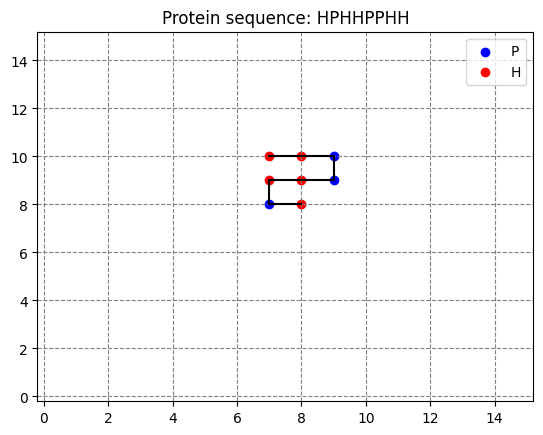

In [10]:
grid_size = 2*n - 1
x = ILP_graph_formulation(protein_binary_sequence, grid_size, additional_constr=True, reduced=False)
positions = grid_positions_from_optimal(x)
plot_folding(protein_binary_sequence, protein_sequence, positions, grid_size)

## Alternatives

### Reduced number of variables

Set parameter Username
Academic license - for non-commercial use only - expires 2024-05-18
Read LP format model from file /var/folders/57/yk3w62md44z9m6ndy61mkkz80000gn/T/tmp_qgz1us8.pyomo.lp
Reading time = 0.00 seconds
x10501: 311 rows, 545 columns, 1822 nonzeros
Gurobi Optimizer version 10.0.1 build v10.0.1rc0 (mac64[arm])

CPU model: Apple M1 Pro
Thread count: 10 physical cores, 10 logical processors, using up to 10 threads

Optimize a model with 311 rows, 545 columns and 1822 nonzeros
Model fingerprint: 0x66b38d65
Variable types: 1 continuous, 544 integer (544 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+00]
Found heuristic solution: objective 2.0000000
Presolve removed 310 rows and 543 columns
Presolve time: 0.00s
Presolved: 1 rows, 2 columns, 2 nonzeros
Variable types: 0 continuous, 2 integer (2 binary)

Explored 0 nodes (0 simplex iterations) in 0.01 seconds (0.

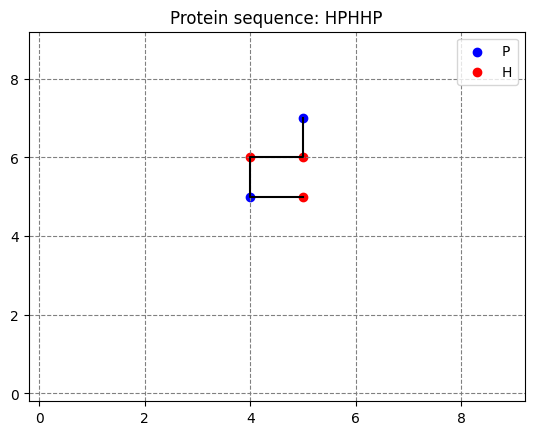

In [42]:
grid_size = 2*n - 1
x = ILP_graph_formulation(protein_binary_sequence, grid_size, additional_constr=False, reduced=True)
positions = grid_positions_from_optimal(x)
plot_folding(protein_binary_sequence, protein_sequence, positions, grid_size)

### Another way : reduce the grid

Set parameter Username
Academic license - for non-commercial use only - expires 2024-05-18
Read LP format model from file /var/folders/57/yk3w62md44z9m6ndy61mkkz80000gn/T/tmp3e3o1_ts.pyomo.lp
Reading time = 0.00 seconds
x1401: 298 rows, 234 columns, 1420 nonzeros
Gurobi Optimizer version 10.0.1 build v10.0.1rc0 (mac64[arm])

CPU model: Apple M1 Pro
Thread count: 10 physical cores, 10 logical processors, using up to 10 threads

Optimize a model with 298 rows, 234 columns and 1420 nonzeros
Model fingerprint: 0x17e48383
Variable types: 1 continuous, 233 integer (233 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+00]
Found heuristic solution: objective 1.0000000
Presolve removed 207 rows and 170 columns
Presolve time: 0.00s
Presolved: 91 rows, 64 columns, 270 nonzeros
Variable types: 0 continuous, 64 integer (64 binary)

Root relaxation: objective 3.000000e+00, 45 iterations

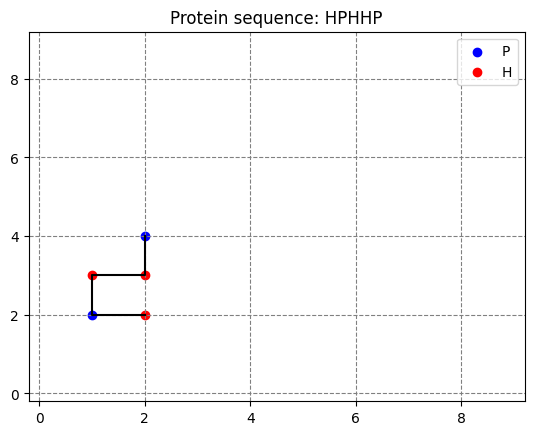

In [43]:
import networkx as nx

def ILP_graph_formulation_reduced_grid(binary_seq):
    model = ConcreteModel()

    ###################
    #   VARIABLES     #
    ###################

    n = len(binary_seq) # sequence length
    p = int(n/2)

    # Set of indices
    model.K = RangeSet(0, n - 1)    # set of indexes in sequence 
    model.K1 = RangeSet(0, n - 2)
    model.I = RangeSet(n - p, 2*n - 1) 
    model.J = RangeSet(n - p, n + p)
    model.H = Set(initialize=get_hydrophobic_set(binary_seq))   # set of indexes in sequence where value is 1 (hydrophobic)

    # Decision Variables
    model.x = Var(model.K, model.I, model.J, within=Binary)
    model.y = Var(model.I, model.J, model.I, model.J, within=Binary)

    G = nx.Graph()

    n = len(binary_seq)

    # add nodes
    for i in model.I:
        for j in model.J:
                G.add_node( (i, j) )

    # add edges
    for i, j in G.nodes():
         for u, v in G.nodes():
              if is_adjacent(i, j, u, v):
                   G.add_edge( (i, j), (u, v) )

    ###################
    #   CONSTRAINTS   #
    ###################

    model.constraints = ConstraintList()

    # the first amino acid is placed on the center of the grid (n,n)
    model.constraints.add(expr = ( model.x[0, n, n] == 1 ) )

    # each vertex has at most one amino acid
    for i in model.I:
        for j in model.J:
            model.constraints.add(expr = ( sum( model.x[k, i, j] for k in model.K ) <= 1 ) )
        
    # each amino acid is placed at exactly one vertex
    for k in model.K:
        model.constraints.add(expr = ( sum( model.x[k, i, j] for i in model.I for j in model.J ) == 1 ) )

    # if amino acid k is placed at (i, j) then amino acid k+1 is placed at a vertex (u, v) adjacent
    # to vertex (i, j)
    for k in model.K1:
        for i in model.I:
            for j in model.J:
                try:
                    model.constraints.add(expr = ( model.x[k, i, j] <= sum( model.x[k+1, u, v] for (u, v) in G[(i,j)] ) ) )
                except:
                    # if node is not in edges
                    pass
    

    # we want y[i, j ,u, v]=1 only if an H amino acid is placed at (i,j) and another amino acid H is placed at a neighboring vertex
    for ((i, j), (u, v)) in G.edges():
        model.constraints.add(expr = ( model.y[i, j, u, v] <= sum( model.x[k, i, j] for k in model.H ) ) )
        model.constraints.add(expr = ( model.y[i, j, u, v] <= sum( model.x[k, u, v] for k in model.H ) ) )


    ###################
    #   OBJECTIVE     #
    ###################
    model.obj = Objective(expr = ( sum( model.y[i, j, u, v] for ((i, j), (u, v)) in G.edges() ) ), sense = maximize)


    ###################
    #   SOLVER        #
    ###################
    sol = SolverFactory('gurobi').solve(model, tee=True)

    # CHECK SOLUTION STATUS

    # Get a JSON representation of the solution
    sol_json = sol.json_repn()

    if sol_json['Solver'][0]['Status'] == 'ok':
        print("Optimal solution value:", model.obj())
        print("\tValues of the decision variables:", ) 
    else:
        print('Error in solving the model')
    
    return [[[model.x[k, i, j]() for j in model.J] for i in model.I] for k in model.K]


grid_size = 2*n - 1
x = ILP_graph_formulation_reduced_grid(protein_binary_sequence)
positions = grid_positions_from_optimal(x)
plot_folding(protein_binary_sequence, protein_sequence, positions, grid_size)

### Alternative formulation

Set parameter Username
Academic license - for non-commercial use only - expires 2024-05-18
Read LP format model from file /var/folders/57/yk3w62md44z9m6ndy61mkkz80000gn/T/tmp4yu7l5lv.pyomo.lp
Reading time = 0.00 seconds
x1477: 142 rows, 201 columns, 741 nonzeros
Gurobi Optimizer version 10.0.1 build v10.0.1rc0 (mac64[arm])

CPU model: Apple M1 Pro
Thread count: 10 physical cores, 10 logical processors, using up to 10 threads

Optimize a model with 142 rows, 201 columns and 741 nonzeros
Model fingerprint: 0x48960cac
Variable types: 1 continuous, 200 integer (200 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+00]
Found heuristic solution: objective -0.0000000
Presolve removed 1 rows and 1 columns
Presolve time: 0.00s
Presolved: 141 rows, 200 columns, 740 nonzeros
Variable types: 0 continuous, 200 integer (200 binary)

Root relaxation: objective 4.153846e+00, 170 iterations

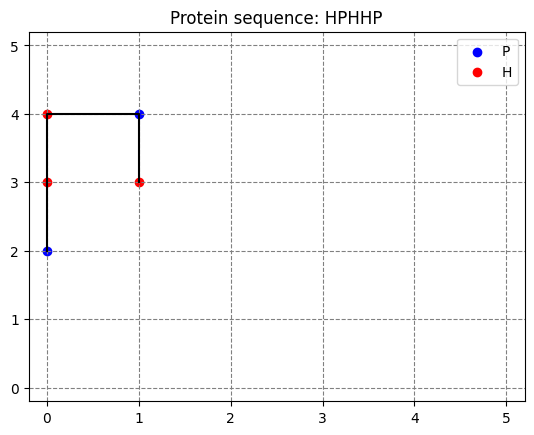

In [44]:
# No reduction of variables

grid_size = n
x = ILP_graph_formulation(protein_binary_sequence, grid_size, additional_constr=False, reduced=False, formulation="alternative")
positions = grid_positions_from_optimal(x)
plot_folding(protein_binary_sequence, protein_sequence, positions, grid_size)

Set parameter Username
Academic license - for non-commercial use only - expires 2024-05-18
Read LP format model from file /var/folders/57/yk3w62md44z9m6ndy61mkkz80000gn/T/tmp8z_iamxn.pyomo.lp
Reading time = 0.00 seconds
x2647: 133 rows, 261 columns, 779 nonzeros
Gurobi Optimizer version 10.0.1 build v10.0.1rc0 (mac64[arm])

CPU model: Apple M1 Pro
Thread count: 10 physical cores, 10 logical processors, using up to 10 threads

Optimize a model with 133 rows, 261 columns and 779 nonzeros
Model fingerprint: 0x397c4d20
Variable types: 1 continuous, 260 integer (260 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+00]
Found heuristic solution: objective -0.0000000
Presolve removed 1 rows and 1 columns
Presolve time: 0.00s
Presolved: 132 rows, 260 columns, 778 nonzeros
Variable types: 0 continuous, 260 integer (260 binary)

Root relaxation: objective 3.900000e+00, 124 iterations

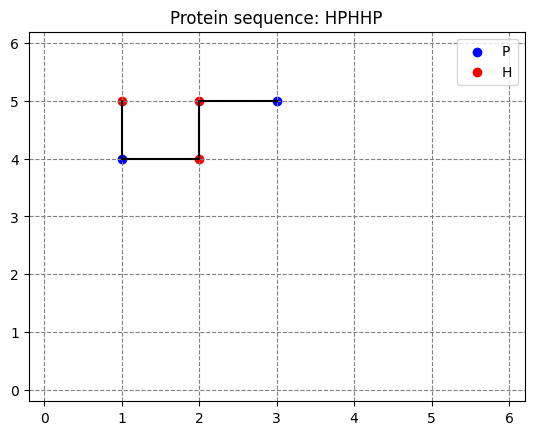

In [45]:
# We increase the grid to (n+1)x(n+1) and we simplify in an analogous way to the original formulation

grid_size = n+1
x = ILP_graph_formulation(protein_binary_sequence, grid_size, additional_constr=False, reduced=True, formulation="alternative")
positions = grid_positions_from_optimal(x)
plot_folding(protein_binary_sequence, protein_sequence, positions, grid_size)